1. Подготовить пайплайн для детекции животных (на выходной картинке у вас выделенная обасть с животными и класс, к которому он пренадлежит (жираф, медведь, собака и тд)

In [26]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

In [28]:
class YOLOTrain(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = None

    def predict(self, X):
        self.model = YOLO("yolo-Weights/yolov8m.pt")
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model(X)
        return y_pred

    def save_new(self, y_pred):
        for r in y_pred:
          im_array = r.plot()  # plot a BGR numpy array of predictions
          im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
          plt.imshow(im)  # show image
        return im.save('results_yolo.jpg')

100%|██████████| 49.7M/49.7M [00:00<00:00, 58.7MB/s]



image 1/1 /content/dog.jpg: 640x640 1 dog, 37.4ms
Speed: 18.9ms preprocess, 37.4ms inference, 849.5ms postprocess per image at shape (1, 3, 640, 640)


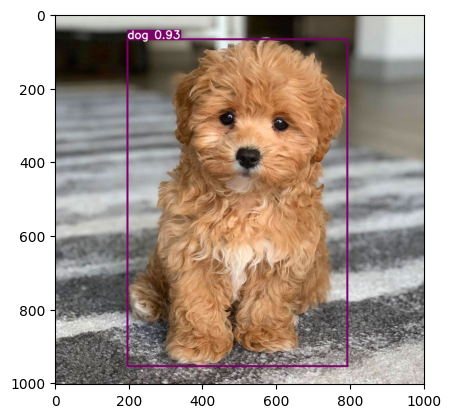

In [29]:
pipe = Pipeline(steps=[
    ('neural_network_trainer', YOLOTrain())
])

y_pred = pipe.predict('/content/dog.jpg')
save = pipe.named_steps['neural_network_trainer'].save_new(y_pred)

2. Детекция и распознование лица партнера (на выходе пайплайна изображение (а лучше видео) где выделена область лица и подписано имя партнера, если это он/она, и если нет, то подписать не идентифицирован)


In [30]:
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

In [41]:
class FaceDetection(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=60):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
        self.threshold = threshold
        self.saved_features = None

  def fit(self, X=None, y=None):
        try:
            self.saved_features = np.load('Hardy_features.npy')
        except FileNotFoundError:
            print("No saved features found. Skipping loading.")
        return self

  def transform(self, X):
        features = []
        for img_path in X:
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)
            for (x, y, w, h) in faces:
                face_roi = img[y:y+h, x:x+w]
                face_img = cv2.resize(face_roi, (224, 224))
                x = img_to_array(face_img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                feature = self.model.predict(x)
                features.append(feature.flatten())
        return np.array(features)

  def save_features(self, features, filename='Hardy_features.npy'):
        np.save(filename, features)
        self.saved_features = features
        print(f"Features saved to {filename}")

  def is_match(self, new_features):
        distance = np.linalg.norm(self.saved_features - new_features)
        return distance < self.threshold

  def display_image_with_results(self, img_path, features):
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            if self.is_match(features):
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(img, "Tom", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(img, "Not Tom", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Features saved to Hardy_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


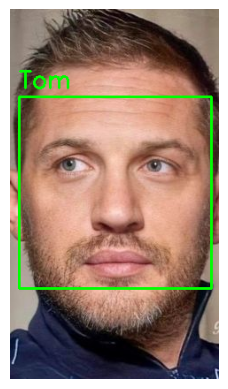

In [42]:
pipe = Pipeline(steps=[
    ('face_detection', FaceDetection())
])

pipe.fit(None)

saved_img_path = '/content/Hardy.jpg'
saved_features = pipe.transform([saved_img_path])
pipe.named_steps['face_detection'].save_features(saved_features)

new_image_path = '/content/hardy1.jpg'
new_features = pipe.transform([new_image_path])
pipe.named_steps['face_detection'].display_image_with_results(new_image_path, new_features[0])

3. перенос стиля (подготовить пайплайн для фото и видео с переносом стиля (эскиз и два на ваш выбор)

In [33]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_hub as hub
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [34]:
class TrasferStylePhoto(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

    def load_photo(self, X, Y):
      content_image = plt.imread(X)
      style_image = plt.imread(Y) #style

      content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
      style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.
      style_image = tf.image.resize(style_image, (256, 256))

      return content_image, style_image

    def predict(self, X, Y):
      content_image, style_image = self.load_photo(X, Y)
      stylized_image = self.model(tf.constant(content_image), tf.constant(style_image))[0]

      return stylized_image

    def plot_images(self, content_image, style_image, stylized_image):
      plt.figure(figsize=(30,30))
      plt.subplot(5,5,1)
      plt.title("Base Image",fontsize=20)
      plt.imshow(np.squeeze(content_image))

      plt.figure(figsize=(30,30))
      plt.subplot(5,5,1+1)
      plt.title("Style Image",fontsize=20)
      plt.imshow(np.squeeze(style_image))

      plt.figure(figsize=(30,30))
      plt.subplot(5,5,1+2)
      plt.title("Final Image",fontsize=20)
      plt.imshow(np.squeeze(stylized_image))

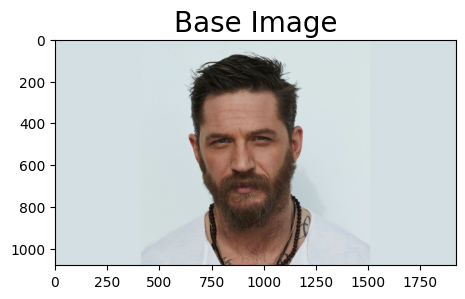

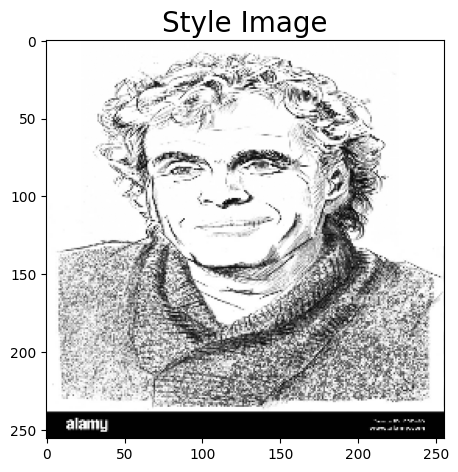

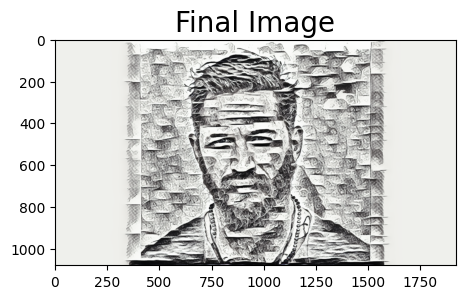

In [35]:
pipe = Pipeline(steps=[
    ('model', TrasferStylePhoto())
])

content_image, style_image = pipe.named_steps['model'].load_photo('/content/Hardy.jpg', '/content/draw.jpg')
stylized_image = pipe.named_steps['model'].predict('/content/Hardy.jpg', '/content/draw.jpg')
pipe.named_steps['model'].plot_images(content_image, style_image, stylized_image)


In [36]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_hub as hub
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [37]:
class TrasferStyleVideo(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

    def load_image(self, image_path):
      img = plt.imread(image_path)
      img = img.astype(np.float32)[np.newaxis, ...] / 255.
      return img

    def stylize_image(self, content_image, style_image):
      style_image = tf.image.resize(style_image, (256, 256))
      stylized_image = self.model(tf.constant(content_image), tf.constant(style_image))[0]
      return stylized_image

    def predict(self, X, Y):
      img = self.load_image(X)
      style_image = self.load_image(Y)
      stylized_image = self.model(tf.constant(img), tf.constant(style_image))[0]

      return stylized_image

    def trasfer_style(self, style_image, video):
      cap = cv2.VideoCapture(video) #video

      frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      fps = int(cap.get(cv2.CAP_PROP_FPS))
      total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

      output_video_path = '/content/output_video_transfer_style.mp4'
      out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

      frame_count = 0
      while cap.isOpened():
          ret, frame = cap.read()
          if not ret:
              break

          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          frame = frame.astype(np.float32)[np.newaxis, ...] / 255.

          stylized_frame = self.stylize_image(frame, style_image)
          stylized_frame = np.squeeze(stylized_frame)
          stylized_frame = (stylized_frame * 255).astype(np.uint8)
          stylized_frame = cv2.cvtColor(stylized_frame, cv2.COLOR_RGB2BGR)

          out.write(stylized_frame)

          frame_count += 1
          if frame_count % 10 == 0:
              print(f'Processed {frame_count}/{total_frames} frames')

      cap.release()
      out.release()

      return out

In [38]:
pipe = Pipeline(steps=[
    ('transfer_style', TrasferStyleVideo())
])

stylized_image = pipe.named_steps['transfer_style'].predict('/content/65aa79a02be27d66021e1d9a.jpg', '/content/draw.jpg')
out = pipe.named_steps['transfer_style'].trasfer_style(stylized_image, '/content/v10044g50000c54rm2jc77u3c8sccl1g.mov')

Processed 10/150 frames
Processed 20/150 frames
Processed 30/150 frames
Processed 40/150 frames
Processed 50/150 frames
Processed 60/150 frames
Processed 70/150 frames
Processed 80/150 frames
Processed 90/150 frames
Processed 100/150 frames
Processed 110/150 frames
Processed 120/150 frames
Processed 130/150 frames
Processed 140/150 frames
Processed 150/150 frames
